In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
import seaborn as sns

pyo.init_notebook_mode()
sns.set_style("darkgrid")
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

RANDOM_SEED = 42

In [2]:
df = pd.read_csv("credit_card/BankChurners.csv")
df = df.iloc[:, :-2]
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [12]:
df.Card_Category.unique()

array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object)

In [13]:
df.Income_Category.unique()

array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'], dtype=object)

In [14]:
df.Attrition_Flag.unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

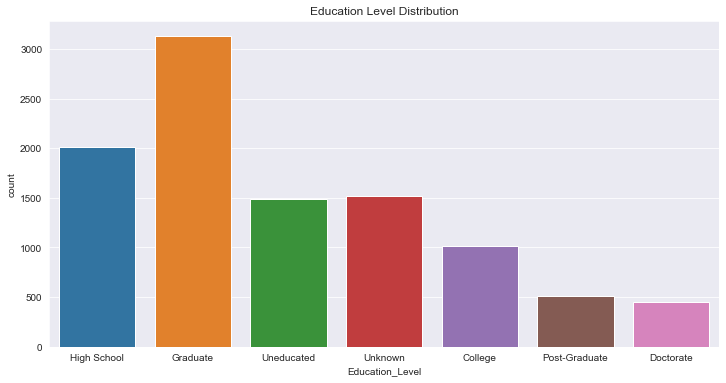

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(df.Education_Level)
plt.title("Education Level Distribution")
plt.show()

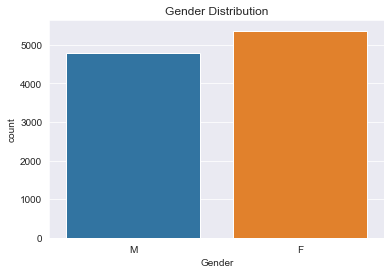

In [34]:
sns.countplot("Gender", data=df)
plt.title("Gender Distribution")
plt.show()

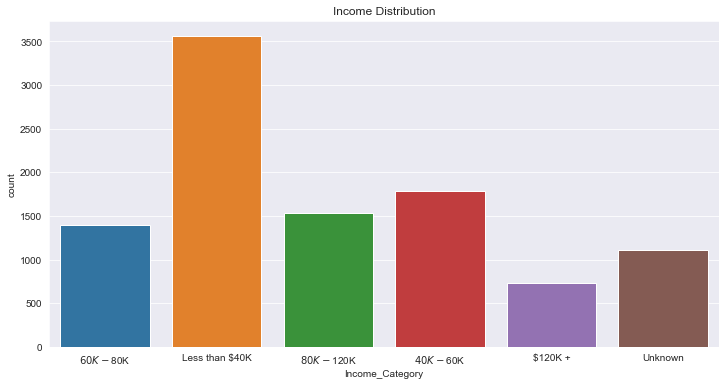

In [33]:
plt.figure(figsize=(12, 6))
sns.countplot("Income_Category", data=df)
plt.title("Income Distribution")
plt.show()

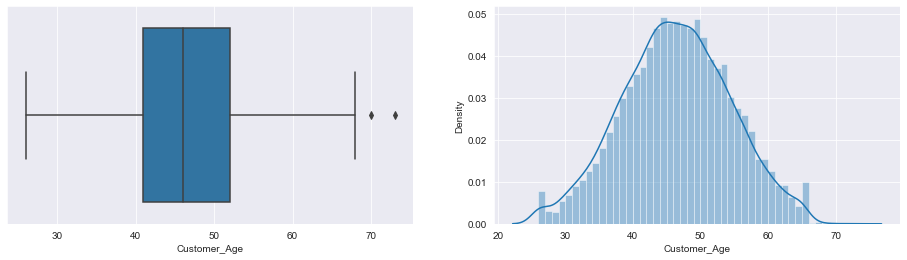

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.boxplot(df.Customer_Age, ax=ax[0])
sns.distplot(df.Customer_Age, ax=ax[1])
plt.show()

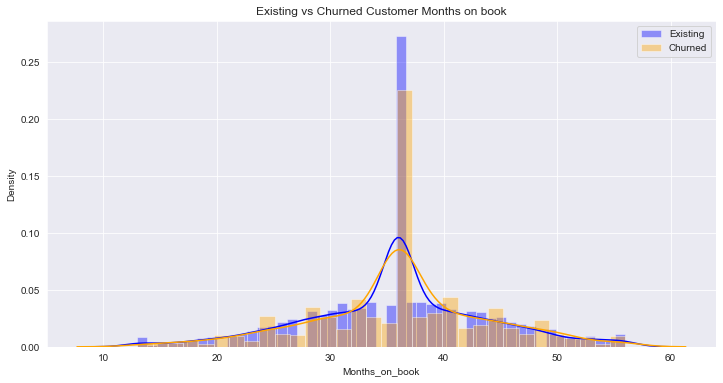

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.distplot(df.query("Attrition_Flag=='Existing Customer'").Months_on_book, color="blue", label="Existing")
sns.distplot(df.query("Attrition_Flag=='Attrited Customer'").Months_on_book, color="orange", label="Churned")
plt.title("Existing vs Churned Customer Months on book")
plt.legend()
plt.show()

In [180]:
df.Gender = pd.Categorical(df.Gender)
df.Income_Category = pd.Categorical(df.Income_Category)
df.Education_Level = pd.Categorical(df.Education_Level)
df.Card_Category = pd.Categorical(df.Card_Category)
df.Marital_Status = pd.Categorical(df.Marital_Status)

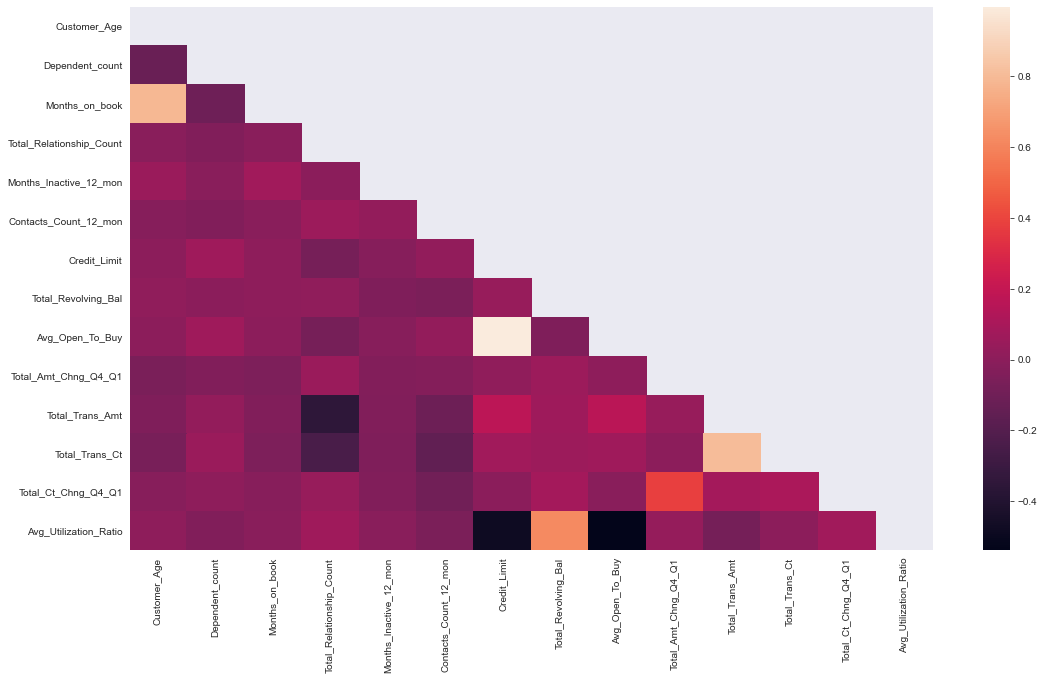

In [67]:
# Checking correlation between numeric features

plt.figure(figsize=(18, 10))
corr = df.iloc[:, 1:].corr()
sns.heatmap(corr, mask=np.triu(corr))
plt.show()

In [206]:
# Creating the dataset with standardized numeric features and one hot encoded categorical features (except for card category,
# which I've modified to be ordinal. There's definitely an order to card category, but the "distance" between each category
# is up for debate. I've just assumed linear)

X = df.copy()
X.drop(columns=["Attrition_Flag", "CLIENTNUM"], inplace=True)
X.Gender = X.Gender.cat.codes

X = pd.concat([X, pd.get_dummies(df.Income_Category)], axis=1)
X = X.drop(columns=["Unknown"])
X = pd.concat([X, pd.get_dummies(df.Marital_Status)], axis=1)
X = X.drop(columns=["Unknown"])
X = pd.concat([X, pd.get_dummies(df.Education_Level)], axis=1)
X.Card_Category = X.Card_Category.map({"Blue": 0, "Silver": 1, "Gold": 2, "Platinum": 3}).astype(int)

numeric_cols = ["Customer_Age", 
                "Dependent_count", 
                "Months_on_book", 
                "Total_Relationship_Count", 
                "Months_Inactive_12_mon",
                "Contacts_Count_12_mon",
                "Credit_Limit",
                "Total_Revolving_Bal",
                "Avg_Open_To_Buy",
                "Total_Amt_Chng_Q4_Q1",
                "Total_Trans_Amt",
                "Total_Trans_Ct",
                "Total_Ct_Chng_Q4_Q1",
                "Avg_Utilization_Ratio",
               ]

X.drop(columns=[
    "Education_Level",
    "Marital_Status",
    "Income_Category"
], inplace=True)

y = (df.Attrition_Flag == "Attrited Customer").astype(int)

In [7]:
# Check to make sure everything is now numeric 

X.dtypes

Customer_Age                float64
Gender                         int8
Dependent_count             float64
Card_Category                 int64
Months_on_book              float64
Total_Relationship_Count    float64
Months_Inactive_12_mon      float64
Contacts_Count_12_mon       float64
Credit_Limit                float64
Total_Revolving_Bal         float64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt             float64
Total_Trans_Ct              float64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
$120K +                       uint8
$40K - $60K                   uint8
$60K - $80K                   uint8
$80K - $120K                  uint8
Less than $40K                uint8
Divorced                      uint8
Married                       uint8
Single                        uint8
College                       uint8
Doctorate                     uint8
Graduate                      uint8
High School                 

In [207]:
# Break data into training and test sets. Later on I'll also break the data up even further for a validation set, which 
# I'll be using to fine tune a model before the final evaluation on the test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [208]:
# Starting simple with logistic regression
# Using as a baseline

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=RANDOM_SEED)
clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [209]:
cross_val_score(clf, X_test, y_test)

array([0.88486842, 0.91611842, 0.89802632, 0.88651316, 0.91433278])

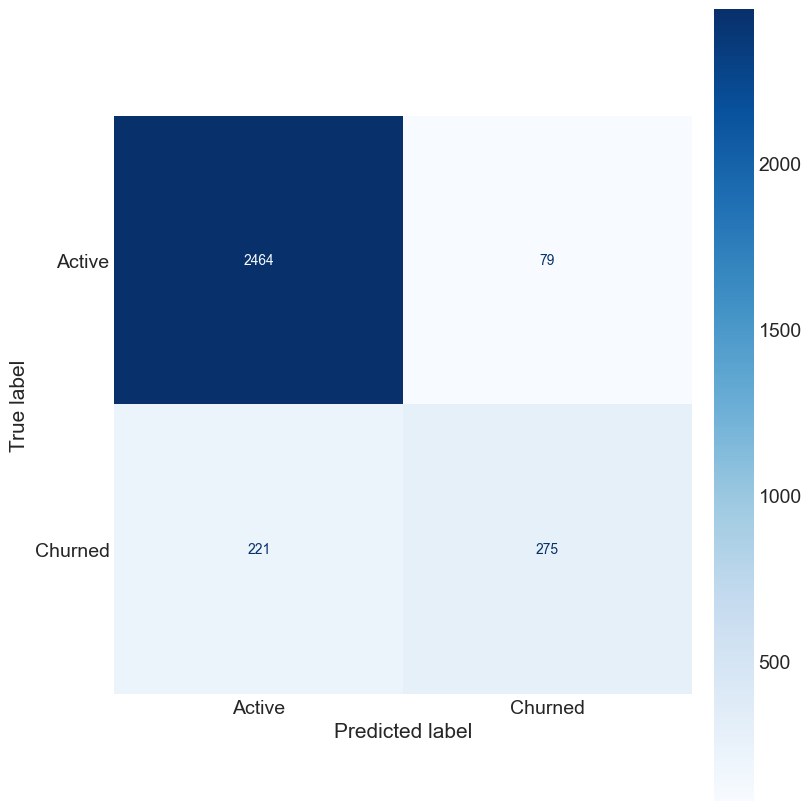

In [212]:
from sklearn.metrics import plot_confusion_matrix

# Plain old Logistic Regression without any upsampling doesn't perform well 
# First I'll try upsampling the churned class for training before moving on to another method

fig, ax = plt.subplots(figsize=(8, 8))
ax.grid(False)
plot_confusion_matrix(clf, X_test, y_test, ax=ax, cmap=plt.cm.Blues, display_labels=["Active", "Churned"])
plt.show()

In [213]:
# Upsampling the churned class in the training data only. Don't want inflated test set accuracy due to the model 
# "learning" the data generating process of the upsampling

upsample = SMOTE()

X_train, y_train = upsample.fit_resample(X_train, y_train)

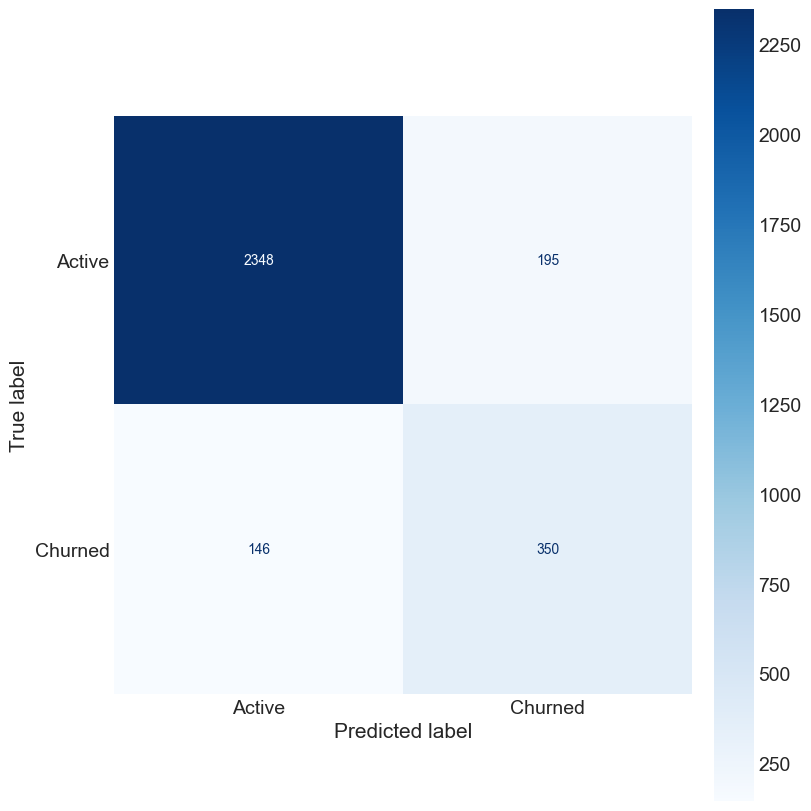

In [215]:
clf.fit(X_train, y_train)

# A bit better in terms of distinguishing between churned class, but still not ideal

fig, ax = plt.subplots(figsize=(8, 8))
ax.grid(False)
plot_confusion_matrix(clf, X_test, y_test, ax=ax, cmap=plt.cm.Blues, display_labels=["Active", "Churned"])
plt.show()

In [216]:
# Take a look at the coefficients to get a general idea of feature importance

pd.DataFrame(np.exp(clf.coef_), columns=X.columns.values, index=["feature_importance"])\
    .T\
    .sort_values(by="feature_importance", ascending=False)

feature_importance
Total_Trans_Amt                     5.838090
Contacts_Count_12_mon               1.859280
Months_Inactive_12_mon              1.780950
Dependent_count                     1.178834
Card_Category                       1.087299
Customer_Age                        1.009730
Avg_Open_To_Buy                     0.990663
Avg_Utilization_Ratio               0.935786
Months_on_book                      0.924552
Credit_Limit                        0.922131
Total_Amt_Chng_Q4_Q1                0.855803
Total_Relationship_Count            0.536659
Total_Ct_Chng_Q4_Q1                 0.522895
Total_Revolving_Bal                 0.451594
Gender                              0.428031
$120K +                             0.352834
$80K - $120K                        0.347420
Less than $40K                      0.326723
$60K - $80K                         0.251103
Single                              0.245054
Divorced                            0.203003
$40K - $60K                         0.197428
Married                             0.175486
Total_Trans_Ct                      0.049690
Graduate                            0.017654
Doctorate                           0.014973
Unknown                             0.014012
High School                         0.013165
Post-Graduate                       0.012668
Uneducated                          0.011170
College                             0.010214

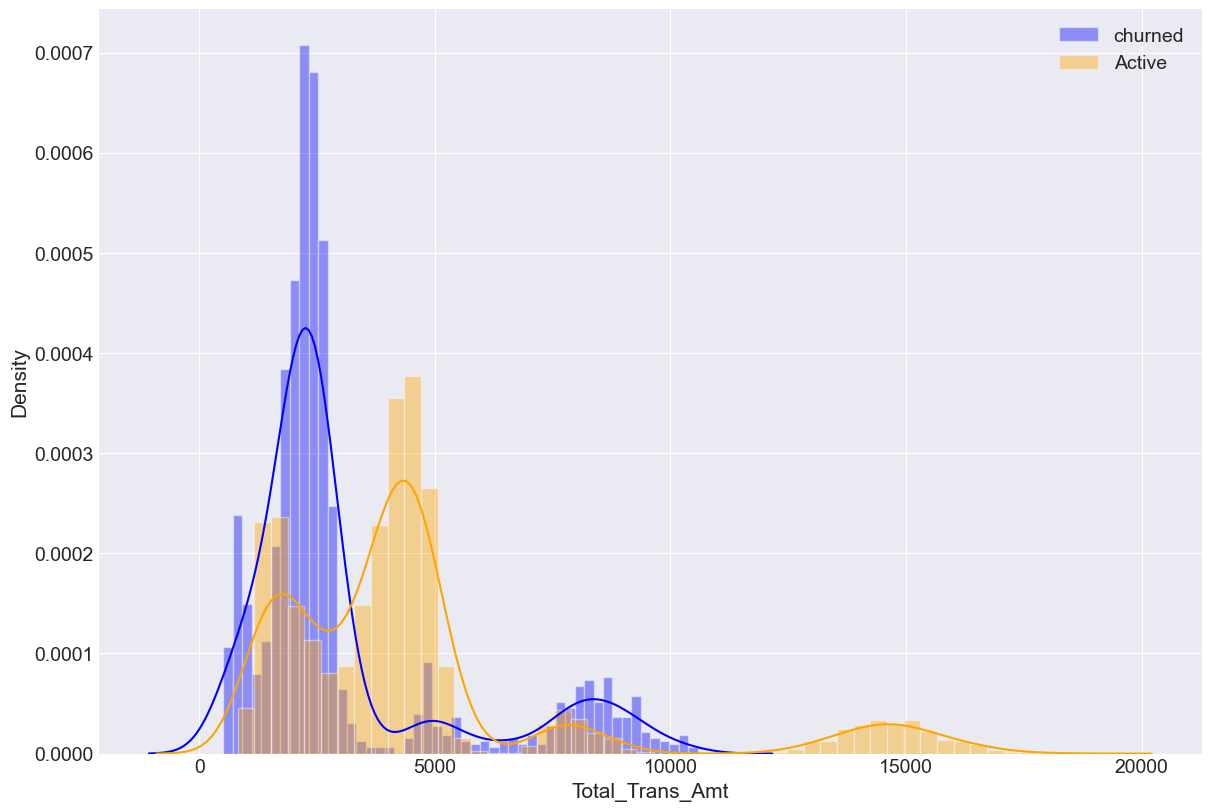

In [217]:
# Sanity check to see if the large weight associated with `Total_Trans_Amt` makes sense given the data.
# Looks promising and makes sense that active customers would have higher total transaction amounts on average.

# Although this feature alone would be problematic for new customers with low transaction amounts

fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(X[y == 1].Total_Trans_Amt, ax=ax, color="blue", label="churned")
sns.distplot(X[y == 0].Total_Trans_Amt, ax=ax, color="orange", label="Active")
plt.legend()
plt.show()

In [218]:
# Moving on to try some non-linear models, starting with a random forest followed by gradient boosted decision trees
from sklearn.ensemble import RandomForestClassifier

# Also going to put more weight on the churned class. IMHO, the cost of attempting to reengage an active user who was 
# mislabeled is less than the cost of missing the opportunity to reengage a churned user who was predicted to be active.

# That being said, determining class weight needs to include business stakeholders. The intended use of the model by end 
# users should be guiding this decision.

active_weight = 1.0
churned_weight = 2.0
rfc = RandomForestClassifier(random_state=RANDOM_SEED, class_weight={0: active_weight, 1: churned_weight})
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.0, 1: 2.0}, random_state=42)

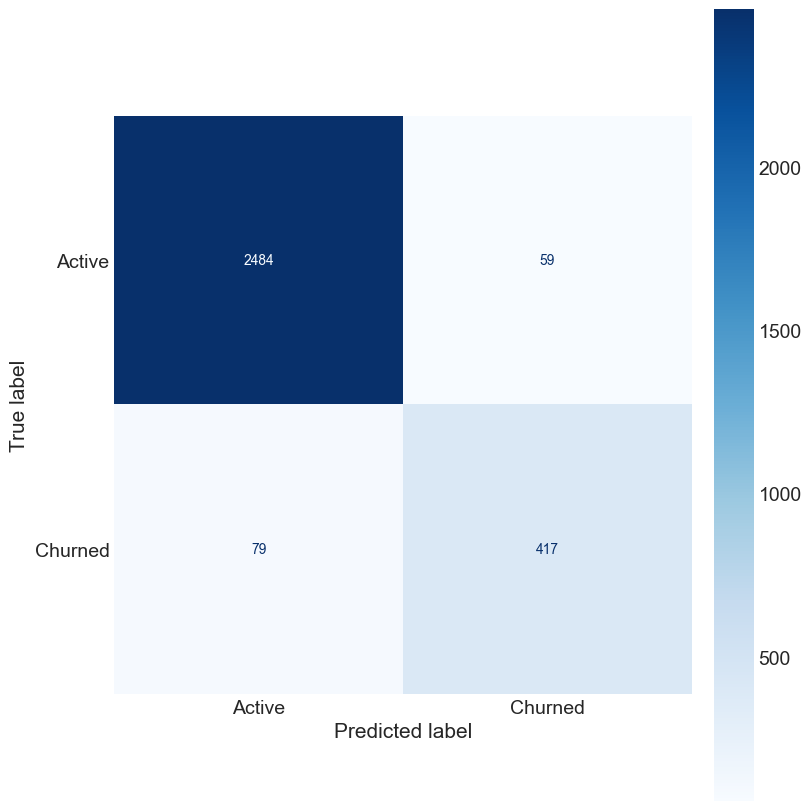

In [219]:
# Even without any hyperparameter tuning (aside from class weights), the random forest classifier does a much better job
# at distinguishing the churned class (~85% correctly labeled) than the previous logistic regression models 
# (~70% after upsampling)

fig, ax = plt.subplots(figsize=(8, 8))
ax.grid(False)
plot_confusion_matrix(rfc, X_test, y_test, ax=ax, cmap=plt.cm.Blues, display_labels=["Active", "Churned"])
plt.show()

In [221]:
# Before moving on, I want to inspect the resulting model a bit more

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rfc, X_test, y_test)

In [222]:
# Again we see the total transaction feature at the top. In this case the count is most important, which we saw was highly
# correlated with the amount in the correlation matrix above.

# When building the final model, I'll prune some of the highly correlated features to reduce any multicollinearity issues or
# misleading feature importances

pd.DataFrame(data={"importance_mean": perm_importance["importances_mean"], 
              "importance_std": perm_importance["importances_std"]}, index=X.columns.values)\
    .sort_values(by="importance_mean", ascending=False)

importance_mean  importance_std
Total_Trans_Ct               1.216848e-01        0.005621
Total_Trans_Amt              4.534386e-02        0.002206
Total_Relationship_Count     2.790392e-02        0.004669
Total_Revolving_Bal          1.711089e-02        0.001396
Total_Ct_Chng_Q4_Q1          1.474169e-02        0.001831
Months_Inactive_12_mon       1.454426e-02        0.001946
Contacts_Count_12_mon        6.383679e-03        0.001524
Total_Amt_Chng_Q4_Q1         5.988812e-03        0.001492
Avg_Open_To_Buy              5.791379e-03        0.001390
Credit_Limit                 5.264890e-03        0.001159
Customer_Age                 4.475156e-03        0.000678
Gender                       3.751234e-03        0.001073
Married                      2.632445e-03        0.000750
Months_on_book               2.105956e-03        0.001132
Uneducated                   1.776900e-03        0.000161
$60K - $80K                  1.579467e-03        0.000484
Avg_Utilization_Ratio        9.871668e-04        0.001020
Single                       7.239223e-04        0.000526
Card_Category                3.948667e-04        0.000246
Dependent_count              3.290556e-04        0.001081
Doctorate                    2.632445e-04        0.000132
$40K - $60K                  1.974334e-04        0.000739
High School                  6.581112e-05        0.000384
Graduate                     6.581112e-05        0.000322
Divorced                     4.440892e-17        0.000416
$80K - $120K                 2.220446e-17        0.000998
$120K +                      0.000000e+00        0.000000
Less than $40K              -6.581112e-05        0.000566
Post-Graduate               -1.974334e-04        0.000161
Unknown                     -3.948667e-04        0.000322
College                     -1.250411e-03        0.000384

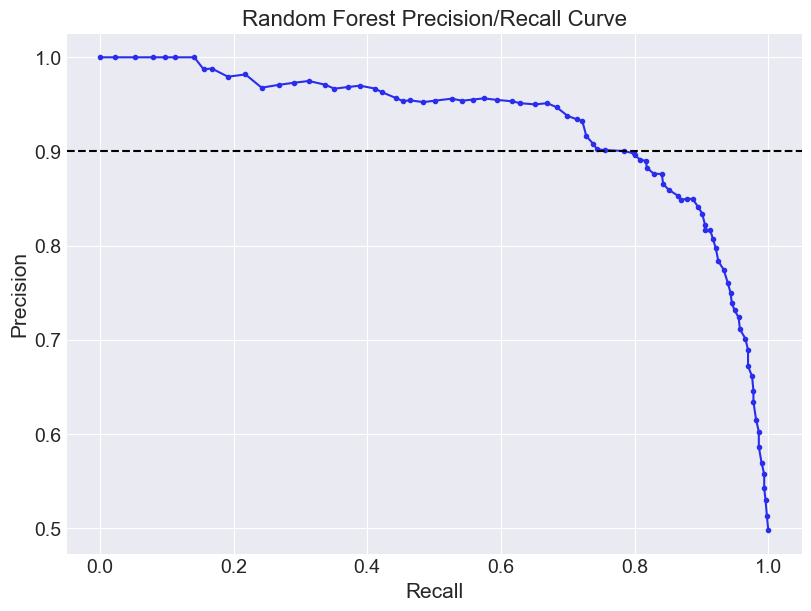

In [225]:
from sklearn.metrics import precision_recall_curve

# Using pr curve instead of auc due to imbalanced classes

fig, ax = plt.subplots(figsize=(8, 6))
prec, rec, _ = precision_recall_curve(y_test, rfc.predict_proba(X_test)[:, 1])
ax.plot(rec, prec, marker=".", label="RF")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.title("Random Forest Precision/Recall Curve")
plt.axhline(y=0.9, color="black", ls="--")
plt.show()

In [226]:
import xgboost as xgb
from sklearn.model_selection import KFold

# Recommended scaling for positive class = total_negative / total_positive when using xgboost
pos_weight_scale = len(y[y==0])/len(y[y==1])
xgb_model = xgb.XGBClassifier(random_state=RANDOM_SEED,
                              scale_pos_weight=pos_weight_scale).fit(X_train, y_train)

C:\Users\10Eva\.conda\envs\home\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[13:33:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


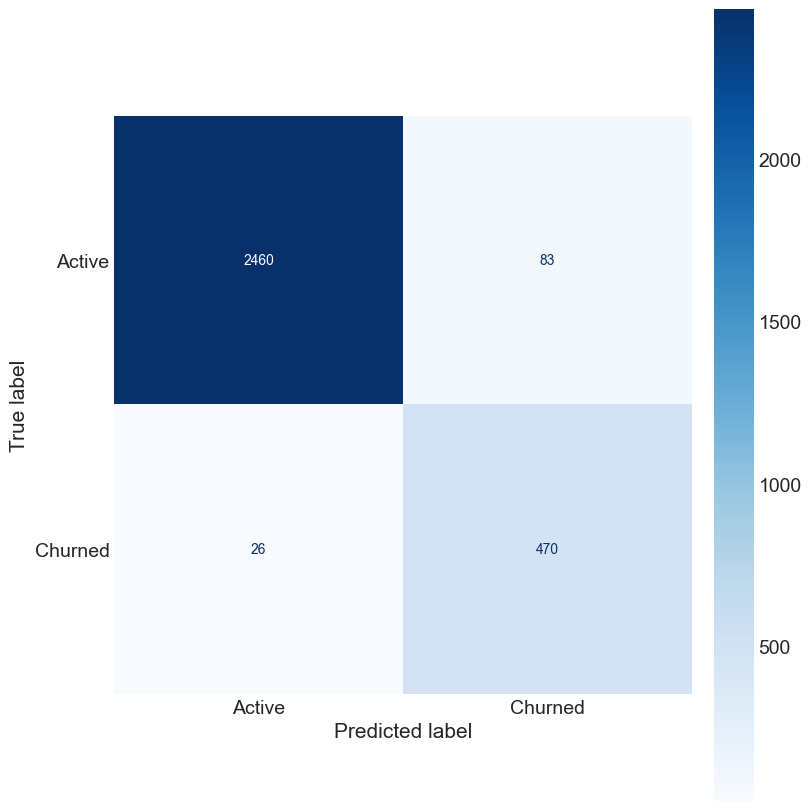

In [227]:
# Even better! Out of the box this model is capturing ~93% of churned customers in the test set
fig, ax = plt.subplots(figsize=(8, 8))
ax.grid(False)
plot_confusion_matrix(xgb_model, X_test, y_test, ax=ax, cmap=plt.cm.Blues, display_labels=["Active", "Churned"])
plt.show()

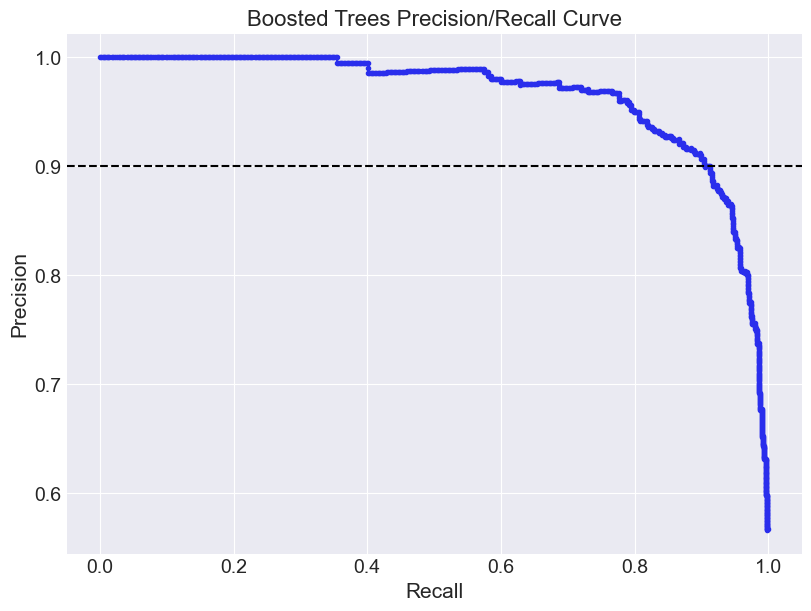

In [228]:
fig, ax = plt.subplots(figsize=(8, 6))
prec, rec, _ = precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
ax.plot(rec, prec, marker=".", label="RF")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.title("Boosted Trees Precision/Recall Curve")
plt.axhline(y=0.9, color="black", ls="--")
plt.show()

In [138]:
# Before moving on to even more complex and less interpretable methods, I'd like to tune the boosted tree model to see
# just how accurate I can get on churn recall, while still trying to keep overall accuracy in the 90% range.

# I'll use the kfold method to produce validation sets out of the training data in order to tune the model, without looking
# at the test set

from sklearn.model_selection import GridSearchCV, StratifiedKFold

params = {
    "objective": ["binary:logistic"],
    "eta": [0.1],
    "max_depth": [2, 8, 16],
    "min_child_weight": [1, 2, 4],
    "lambda": [1, 2, 4],
    "scale_pos_weight": [pos_weight_scale*2.0],
    "nthread": [4],
    "seed": [RANDOM_SEED],
}

base_model = xgb.XGBClassifier()

xgb_model = GridSearchCV(base_model, params, n_jobs=4, 
                        cv=StratifiedKFold(5, shuffle=True),
                        scoring="f1",
                        verbose=3)

In [139]:
xgb_model.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\10Eva\.conda\envs\tensorflow2\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:02:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     miss...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
              

In [142]:
xgb_model.best_params_

{'eta': 0.1,
 'lambda': 1,
 'max_depth': 8,
 'min_child_weight': 2,
 'nthread': 4,
 'objective': 'binary:logistic',
 'scale_pos_weight': 10.448678549477567,
 'seed': 42}

In [140]:
best_model = xgb_model.best_estimator_

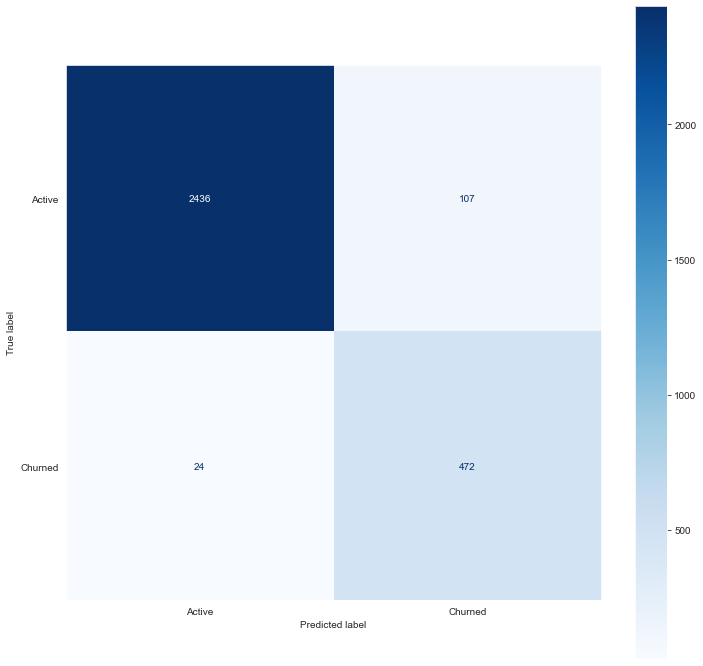

In [141]:
# In the interest of time, I'll use this model as the tuned version - correctly identifying ~ 95% of churned customers
fig, ax = plt.subplots(figsize=(12, 12))
ax.grid(False)
plot_confusion_matrix(best_model, X_test, y_test, ax=ax, cmap=plt.cm.Blues, display_labels=["Active", "Churned"])
plt.show()

In [185]:
def df_to_dataset(df, labels, shuffle=True, batch_size=128):
    df = df.copy()
    dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset

In [229]:
# Now as more of an exercise than a necessity, I'll fit a neural net at the cost of some explainability in hopes of increased
# accuracy. Rather than one hot encoding, I'll train embeddings for some of the categorical features

from imblearn.over_sampling import SMOTENC

embedding_cols = [
    "Income_Category",
    "Education_Level",
]

numeric_cols = ["Customer_Age", 
                "Dependent_count", 
                "Months_on_book", 
                "Total_Relationship_Count", 
                "Months_Inactive_12_mon",
                "Contacts_Count_12_mon",
                "Credit_Limit",
                "Total_Revolving_Bal",
                "Avg_Open_To_Buy",
                "Total_Amt_Chng_Q4_Q1",
                "Total_Trans_Amt",
                "Total_Trans_Ct",
                "Total_Ct_Chng_Q4_Q1",
                "Avg_Utilization_Ratio",
               ]

X_nn = X[numeric_cols].copy()
X_nn = pd.concat([X_nn, pd.Series(df.Gender.cat.codes, name="Gender_enc")], axis=1)
# Remaining categorical columns
X_nn = pd.concat([X_nn, df.drop(columns=(numeric_cols + ["CLIENTNUM", "Attrition_Flag", "Gender"]))], axis=1)

batch_size = 128
X_train, X_test, y_train, y_test = train_test_split(X_nn, y.values, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

smote_nc = SMOTENC(categorical_features=[14, 15, 16, 17, 18], random_state=RANDOM_SEED)
X_train, y_train = smote_nc.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

train_ds = df_to_dataset(X_train, y_train, batch_size=batch_size)
val_ds = df_to_dataset(X_val, y_val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(X_test, y_test, shuffle=False, batch_size=batch_size)

In [191]:
example_batch = next(iter(train_ds))[0]

def demo(feature_column):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [184]:
weight_for_0 = (1 / len(y[y==0])) * (len(y))/2.0
weight_for_1 = (1 / len(y[y==1])) * (len(y))/2.0

print(weight_for_0, weight_for_1)

0.5957058823529412 3.1121696373693912


In [248]:
from IPython import display
import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [288]:

import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow import keras

STEPS_PER_EPOCH = len(X_train)//batch_size

feature_columns = []

for col in numeric_cols:
    feature_columns.append(tf.feature_column.numeric_column(col))

income_cat = tf.feature_column.categorical_column_with_vocabulary_list(
    "Income_Category", df.Income_Category.cat.categories.values)
income_embedding = tf.feature_column.embedding_column(income_cat, dimension=2)
feature_columns.append(income_embedding)

edu_cat = tf.feature_column.categorical_column_with_vocabulary_list(
    "Education_Level", df.Education_Level.cat.categories.values)
edu_embedding = tf.feature_column.embedding_column(edu_cat, dimension=2)
feature_columns.append(edu_embedding)

ms_cat = tf.feature_column.categorical_column_with_vocabulary_list(
    "Marital_Status", df.Marital_Status.cat.categories.values)
ms_one_hot = tf.feature_column.indicator_column(ms_cat)
feature_columns.append(ms_one_hot)

card_cat = tf.feature_column.categorical_column_with_vocabulary_list(
    "Card_Category", df.Card_Category.cat.categories.values)
card_one_hot = tf.feature_column.indicator_column(card_cat)
feature_columns.append(card_one_hot)

merged_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
    merged_layer,
    tf.keras.layers.Dense(256, activation="selu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="selu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="selu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="selu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_binary_accuracy",
    verbose=1,
    patience=50,
    mode="max",
    restore_best_weights=True
)

tensorboard = tf.keras.callbacks.TensorBoard(logdir/"churn")

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*50,
    decay_rate=1,
    staircase=False
)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["BinaryAccuracy", "Precision", "Recall"])


In [289]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=300,
          callbacks=[early_stopping, tensorboard],
         )

Epoch 1/300
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
85/85 [==============================] - ETA: 0s - loss: 0.5191 - binary_accuracy: 0.7846 - precision: 0.7821 - recall: 0.7884WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Customer_Age': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float64>, 'Dependent_count': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'Months_on_book': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=float64>, 'Total_Relationship_Count': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=float64>, 'Months_Inactive_12_mon': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=float64>, 'Contacts_Count_12_mon': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'Credit_Limit': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'Total_Revolving_Bal': <tf.Tensor 'ExpandDims_16:0' s

85/85 [==============================] - 3s 32ms/step - loss: 0.1461 - binary_accuracy: 0.9586 - precision: 0.9524 - recall: 0.9662 - val_loss: 0.1946 - val_binary_accuracy: 0.9395 - val_precision: 0.7738 - val_recall: 0.8906
Epoch 48/300
85/85 [==============================] - 3s 32ms/step - loss: 0.1370 - binary_accuracy: 0.9615 - precision: 0.9595 - recall: 0.9639 - val_loss: 0.1941 - val_binary_accuracy: 0.9426 - val_precision: 0.7848 - val_recall: 0.8943
Epoch 49/300
85/85 [==============================] - 3s 32ms/step - loss: 0.1519 - binary_accuracy: 0.9539 - precision: 0.9482 - recall: 0.9605 - val_loss: 0.1984 - val_binary_accuracy: 0.9389 - val_precision: 0.7712 - val_recall: 0.8906
Epoch 50/300
85/85 [==============================] - 3s 33ms/step - loss: 0.1375 - binary_accuracy: 0.9627 - precision: 0.9563 - recall: 0.9688 - val_loss: 0.1814 - val_binary_accuracy: 0.9488 - val_precision: 0.8095 - val_recall: 0.8981
Epoch 51/300
85/85 [==============================] - 3s 

85/85 [==============================] - 3s 32ms/step - loss: 0.1043 - binary_accuracy: 0.9742 - precision: 0.9710 - recall: 0.9782 - val_loss: 0.1539 - val_binary_accuracy: 0.9537 - val_precision: 0.8369 - val_recall: 0.8906
Epoch 116/300
85/85 [==============================] - 3s 32ms/step - loss: 0.1093 - binary_accuracy: 0.9701 - precision: 0.9653 - recall: 0.9746 - val_loss: 0.1614 - val_binary_accuracy: 0.9525 - val_precision: 0.8176 - val_recall: 0.9132
Epoch 117/300
85/85 [==============================] - 3s 32ms/step - loss: 0.1037 - binary_accuracy: 0.9743 - precision: 0.9691 - recall: 0.9797 - val_loss: 0.1613 - val_binary_accuracy: 0.9537 - val_precision: 0.8299 - val_recall: 0.9019
Epoch 118/300
85/85 [==============================] - 3s 32ms/step - loss: 0.1041 - binary_accuracy: 0.9772 - precision: 0.9758 - recall: 0.9787 - val_loss: 0.1619 - val_binary_accuracy: 0.9531 - val_precision: 0.8203 - val_recall: 0.9132
Epoch 119/300
85/85 [==============================] -

85/85 [==============================] - 3s 32ms/step - loss: 0.0963 - binary_accuracy: 0.9750 - precision: 0.9734 - recall: 0.9766 - val_loss: 0.1613 - val_binary_accuracy: 0.9537 - val_precision: 0.8231 - val_recall: 0.9132
Epoch 184/300
85/85 [==============================] - 3s 32ms/step - loss: 0.0895 - binary_accuracy: 0.9783 - precision: 0.9762 - recall: 0.9812 - val_loss: 0.1632 - val_binary_accuracy: 0.9537 - val_precision: 0.8276 - val_recall: 0.9057
Epoch 185/300
85/85 [==============================] - 3s 33ms/step - loss: 0.0920 - binary_accuracy: 0.9770 - precision: 0.9755 - recall: 0.9791 - val_loss: 0.1582 - val_binary_accuracy: 0.9556 - val_precision: 0.8362 - val_recall: 0.9057
Epoch 186/300
85/85 [==============================] - 3s 32ms/step - loss: 0.0922 - binary_accuracy: 0.9770 - precision: 0.9755 - recall: 0.9785 - val_loss: 0.1610 - val_binary_accuracy: 0.9506 - val_precision: 0.8179 - val_recall: 0.8981
Epoch 187/300
85/85 [==============================] -

In [279]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion matrix @ 0.5")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

Consider rewriting this model with the Functional API.


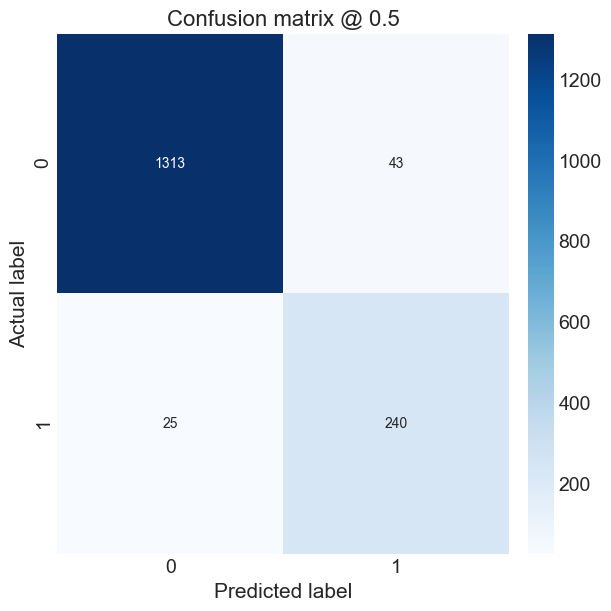

In [290]:
# Confusion matrix of the validation set, used for evaluation and early stopping

val_preds = model.predict(val_ds, batch_size=batch_size)
val_preds = (val_preds > 0.5) * 1.
plot_cm(y_val, val_preds)

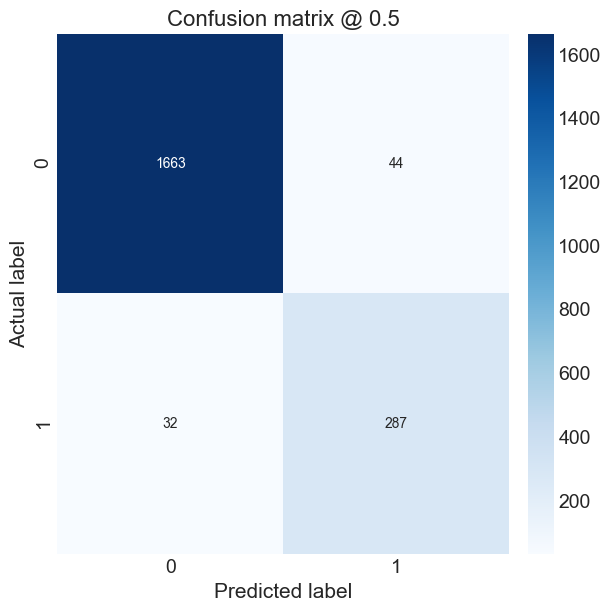

In [291]:
# Confusion matrix of the test set, used to get an idea of how well the model will generalize to new examples

test_preds = model.predict(test_ds, batch_size=batch_size)
test_preds = (test_preds > 0.5) * 1.
plot_cm(y_test, test_preds)

In [246]:
%load_ext tensorboard

%tensorboard --logdir {logdir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 46028.

In [260]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f"Test Accuracy: {round(accuracy, 2)}, Precision: {round(precision, 2)}, Recall: {round(recall, 2)}")

16/16 [==============================] - 0s 21ms/step - loss: 0.1440 - binary_accuracy: 0.9556 - precision: 0.8300 - recall: 0.9028
Test Accuracy: 0.96, Precision: 0.83, Recall: 0.9


In [11]:
# Last model, probabilistic 
import arviz as az
import pymc3 as pm
from scipy.special import expit as logistic

az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

In [24]:
df[numeric_cols].std()

Customer_Age                   8.016814
Dependent_count                1.298908
Months_on_book                 7.986416
Total_Relationship_Count       1.554408
Months_Inactive_12_mon         1.010622
Contacts_Count_12_mon          1.106225
Credit_Limit                9088.776650
Total_Revolving_Bal          814.987335
Avg_Open_To_Buy             9090.685324
Total_Amt_Chng_Q4_Q1           0.219207
Total_Trans_Amt             3397.129254
Total_Trans_Ct                23.472570
Total_Ct_Chng_Q4_Q1            0.238086
Avg_Utilization_Ratio          0.275691
dtype: float64

In [78]:
from imblearn.over_sampling import SMOTENC
X = df.copy()
X.drop(columns=["Attrition_Flag", "CLIENTNUM"], inplace=True)
X.Gender = X.Gender.cat.codes
X.Card_Category = X.Card_Category.map({"Blue": 0, "Silver": 1, "Gold": 2, "Platinum": 3}).astype(int)

numeric_cols = ["Customer_Age", 
                "Dependent_count", 
                "Months_on_book", 
                "Total_Relationship_Count", 
                "Months_Inactive_12_mon",
                "Contacts_Count_12_mon",
                "Credit_Limit",
                "Total_Revolving_Bal",
                "Avg_Open_To_Buy",
                "Total_Amt_Chng_Q4_Q1",
                "Total_Trans_Amt",
                "Total_Trans_Ct",
                "Total_Ct_Chng_Q4_Q1",
                "Avg_Utilization_Ratio",
               ]

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

y = (df.Attrition_Flag == "Attrited Customer").astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3)

smote_nc = SMOTENC(categorical_features=list(np.where(X.dtypes == 'category')[0]), random_state=RANDOM_SEED)
X_train, y_train = smote_nc.fit_resample(X_train, y_train)


In [146]:
edu_level = X_train.Education_Level.cat.codes
n_edu_level = X.Education_Level.nunique()

income = X_train.Income_Category.cat.codes
n_income = X.Income_Category.nunique()

card = X_train.Card_Category.values
n_card = X.Card_Category.nunique()


customer_ages = X_train.Customer_Age.values
transaction_amounts = X_train.Total_Trans_Amt.values
dependent_count = X_train.Dependent_count.values
target = y_train

with pm.Model() as prob_model:
    # hyper-priors
    edu_mu = pm.Normal("edu_mu", mu=0.0, sigma=.5)
    edu_sigma = pm.Exponential("edu_sigma", 2.)
    card_mu = pm.Normal("card_mu", 0.0, 0.5)
    card_sigma = pm.Exponential("card_sigma", 2.)
    
    # adaptive priors
    # Using StudentT rather than Normal/Gaussian here for some regularization. StudentT allows for thicker tails, and 
    # as a result is less "surprised" when encountering outliers
    edu = pm.StudentT("edu", nu=5, mu=edu_mu, sigma=edu_sigma, shape=n_edu_level)
    crd = pm.StudentT("card", nu=5, mu=card_mu, sigma=card_sigma, shape=n_card)
    
    # priors
    inc = pm.StudentT("income", nu=5, mu=0, sigma=1., shape=n_income)
    age = pm.Normal("age", 0, 1.)
    trans_amt = pm.StudentT("trans_amt", nu=5, mu=0, sigma=1.)
    dep_count = pm.StudentT("dep_count", nu=2, mu=0, sigma=1.)
    
    lineq = pm.Deterministic("lineq", edu[edu_level] + 
        inc[income] + 
        crd[card] +
        age * customer_ages +
        trans_amt * transaction_amounts + 
        dep_count * dependent_count)
    
    p = pm.Deterministic("p", pm.math.invlogit(lineq))
    
    churned = pm.Binomial("churned", 1, p, observed=target)
    
    trace = pm.sample(target_accept=0.95, random_seed=RANDOM_SEED, cores=2, chains=2)
    idata = az.from_pymc3(trace)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [dep_count, trans_amt, age, income, card, edu, card_sigma, card_mu, edu_sigma, edu_mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2478 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [147]:
# Summary of the fitted model
summary = az.summary(trace, var_names=["card", "edu", "income", "age", "trans_amt", "dep_count"])
summary

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
card[0]   -0.275  0.416    -0.881      0.416      0.020    0.014     454.0   
card[1]   -0.469  0.427    -1.190      0.158      0.020    0.014     460.0   
card[2]    0.115  0.437    -0.596      0.788      0.019    0.013     534.0   
card[3]    0.096  0.530    -0.725      0.931      0.021    0.015     658.0   
edu[0]    -0.380  0.427    -1.096      0.282      0.022    0.016     367.0   
edu[1]    -0.187  0.427    -0.818      0.569      0.022    0.016     368.0   
edu[2]     0.356  0.422    -0.288      1.078      0.022    0.016     361.0   
edu[3]    -0.148  0.421    -0.790      0.567      0.022    0.016     365.0   
edu[4]    -0.542  0.431    -1.242      0.149      0.022    0.016     378.0   
edu[5]    -0.145  0.424    -0.851      0.532      0.022    0.016     367.0   
edu[6]     0.060  0.424    -0.610      0.750      0.022    0.016     365.0   
income[0] -0.032  0.353    -0.570      0.555      0.016    0.011     475.0   
income[1] -0.252  0.352    -0.803      0.315      0.016    0.012     475.0   
income[2] -0.343  0.353    -0.867      0.255      0.016    0.011     479.0   
income[3]  0.122  0.354    -0.426      0.697      0.016    0.012     475.0   
income[4]  0.385  0.352    -0.176      0.957      0.016    0.012     471.0   
income[5] -0.198  0.356    -0.779      0.374      0.016    0.012     473.0   
age        0.018  0.021    -0.015      0.051      0.000    0.000    2258.0   
trans_amt -0.741  0.028    -0.786     -0.697      0.001    0.000    1762.0   
dep_count  0.095  0.021     0.061      0.127      0.000    0.000    2166.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
card[0]     454.0     455.0     703.0   1.00  
card[1]     460.0     460.0     675.0   1.00  
card[2]     534.0     534.0     900.0   1.00  
card[3]     658.0     666.0     871.0   1.00  
edu[0]      367.0     367.0     595.0   1.00  
edu[1]      368.0     369.0     534.0   1.00  
edu[2]      361.0     362.0     564.0   1.01  
edu[3]      365.0     365.0     554.0   1.00  
edu[4]      375.0     377.0     684.0   1.01  
edu[5]      367.0     368.0     584.0   1.00  
edu[6]      365.0     366.0     613.0   1.01  
income[0]   475.0     474.0     624.0   1.00  
income[1]   466.0     476.0     636.0   1.00  
income[2]   475.0     480.0     686.0   1.00  
income[3]   429.0     474.0     566.0   1.00  
income[4]   403.0     472.0     619.0   1.00  
income[5]   460.0     472.0     600.0   1.00  
age        1479.0    2238.0    1481.0   1.00  
trans_amt  1734.0    1767.0    1082.0   1.00  
dep_count  2142.0    2178.0    1311.0   1.00

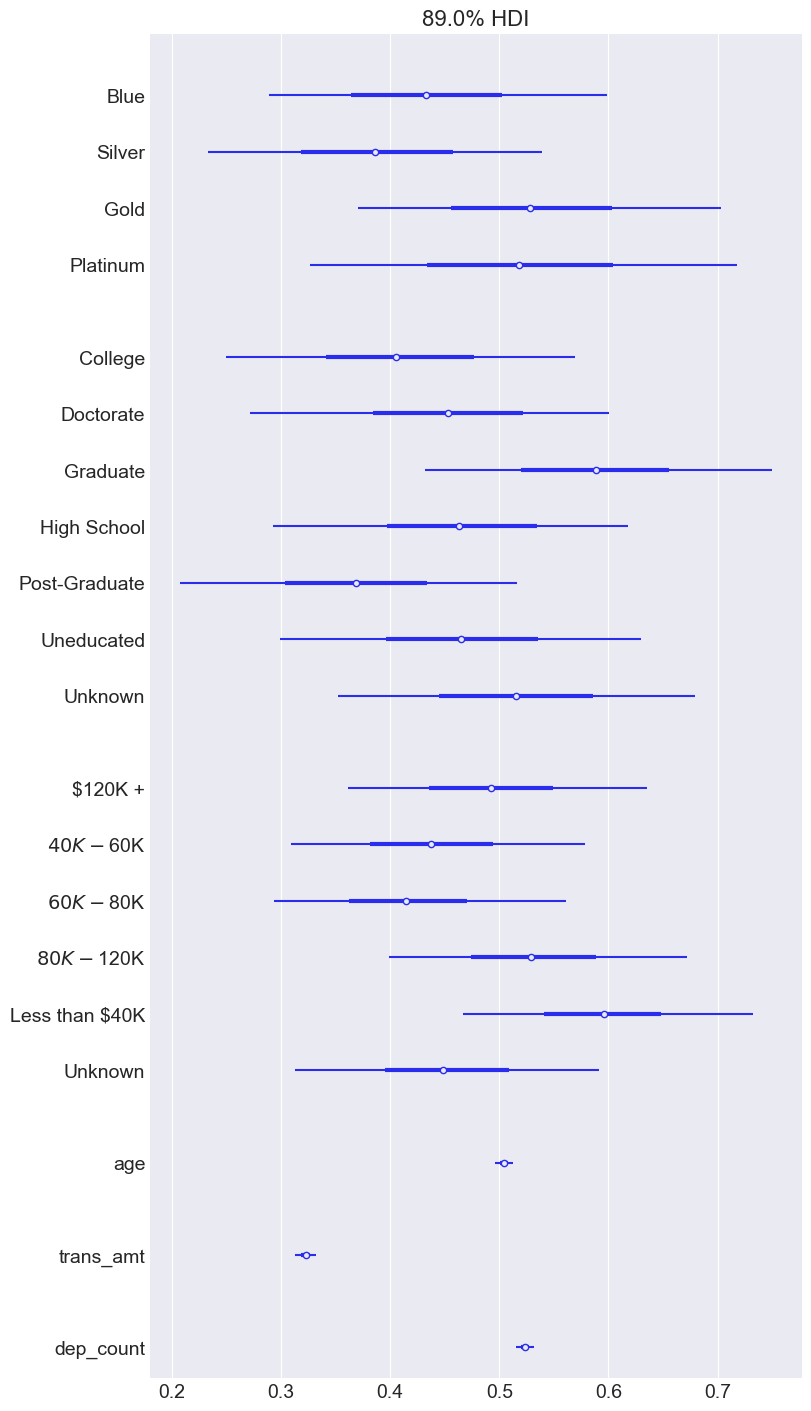

In [173]:
# Looking at the highest density interval plot below, it's important to note only total_transaction_amount and dependent_count
# exclude the "no effect" value of 0.5 in this case (converted from log odds back to probability space when plotting)

fig, ax = plt.subplots(figsize=(8, 14))
az.plot_forest(trace, var_names=["card", "edu", "income", "age", "trans_amt", "dep_count"], combined=True, ax=ax, transform=logistic)
ax.set_yticklabels(list(reversed(["Blue", "Silver", "Gold", "Platinum"] + 
                   list(X.Education_Level.cat.categories.values) + 
                   list(X.Income_Category.cat.categories.values) + 
                   ["age", "trans_amt", "dep_count"])))
plt.show()

In [120]:
for idx, name in enumerate(["Blue", "Silver", "Gold", "Platinum"]):
    card_target = y_train[X_train.Card_Category == idx]
    pct_churn = sum(card_target) / len(card_target)
    print(f"{name} Card users: {len(card_target)}, churn: {round(pct_churn, 2)}")

Blue Card users: 11262, churn: 0.51
Silver Card users: 507, churn: 0.32
Gold Card users: 119, churn: 0.45
Platinum Card users: 16, churn: 0.44


In [138]:
for idx, name in enumerate(X.Education_Level.cat.categories.values):
    edu_target = y_train[X_train.Education_Level == name]
    pct_churn = sum(edu_target) / len(edu_target)
    print(f"{name} Customers: {len(edu_target)}, churn: {round(pct_churn, 2)}")

College Customers: 1030, churn: 0.41
Doctorate Customers: 441, churn: 0.45
Graduate Customers: 4449, churn: 0.59
High School Customers: 2171, churn: 0.44
Post-Graduate Customers: 444, churn: 0.34
Uneducated Customers: 1604, churn: 0.45
Unknown Customers: 1765, churn: 0.5


In [134]:
X_train.Education_Level.value_counts()

Graduate         4449
High School      2171
Unknown          1765
Uneducated       1604
College          1030
Post-Graduate     444
Doctorate         441
Name: Education_Level, dtype: int64

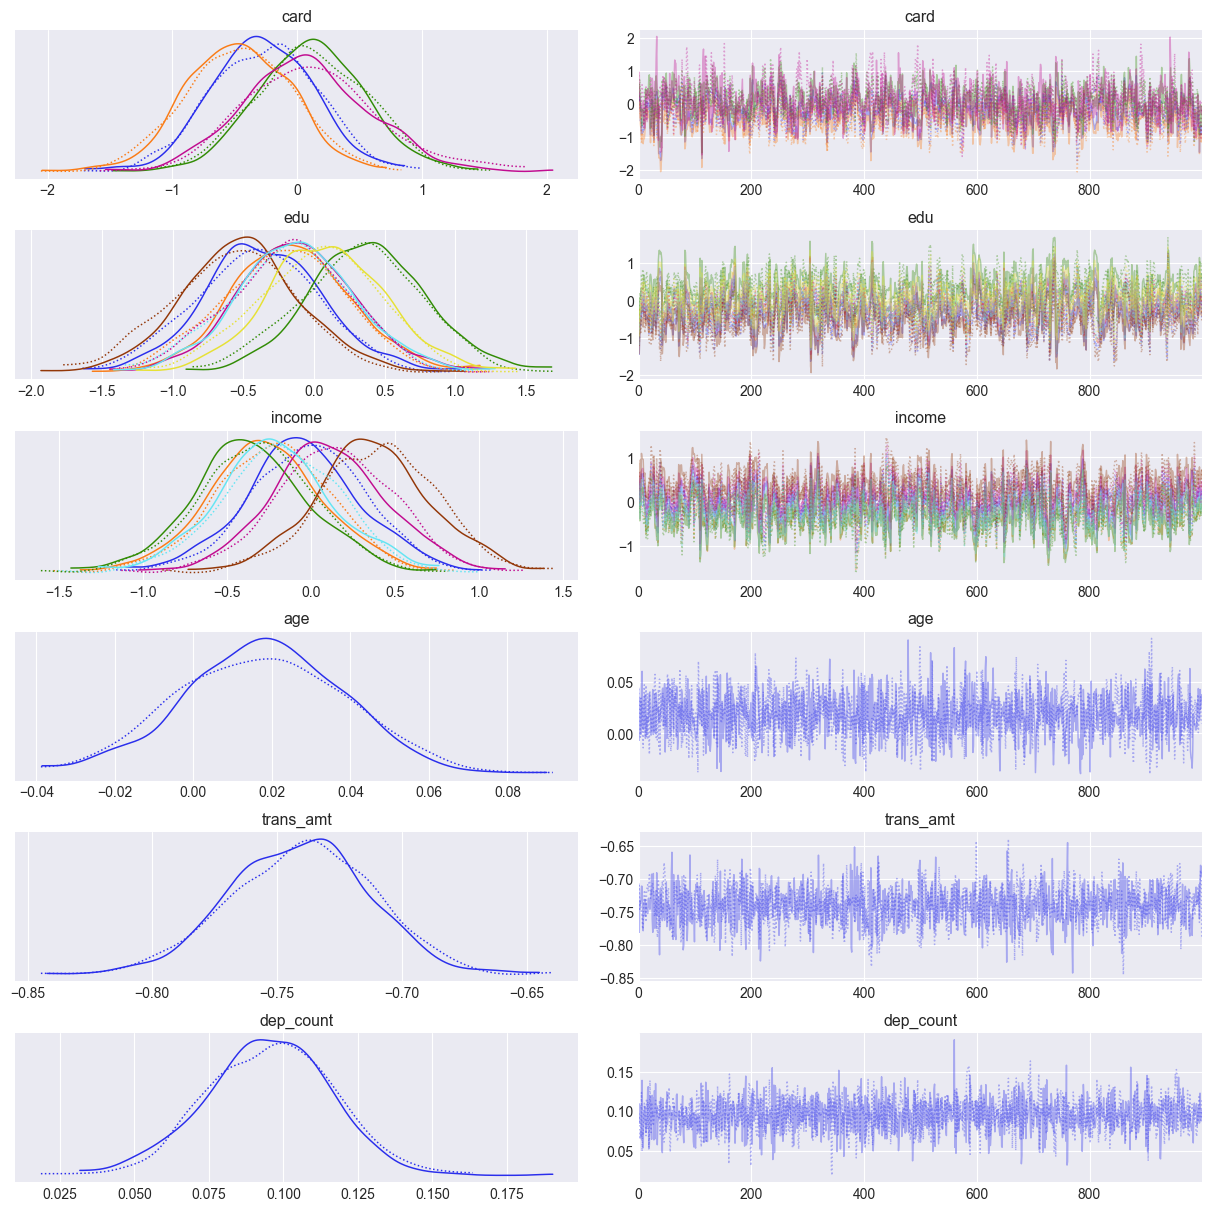

In [149]:
# Check how the model's doing with fitting the data. On the left are kernel density estimation plots and on the right 
# are individual sampled values at each step during sampling (the more evenly squiggly the better, indicating a thorough
# exploration of the parameter space)

az.plot_trace(idata, var_names=["card", "edu", "income", "age", "trans_amt", "dep_count"])
plt.show()

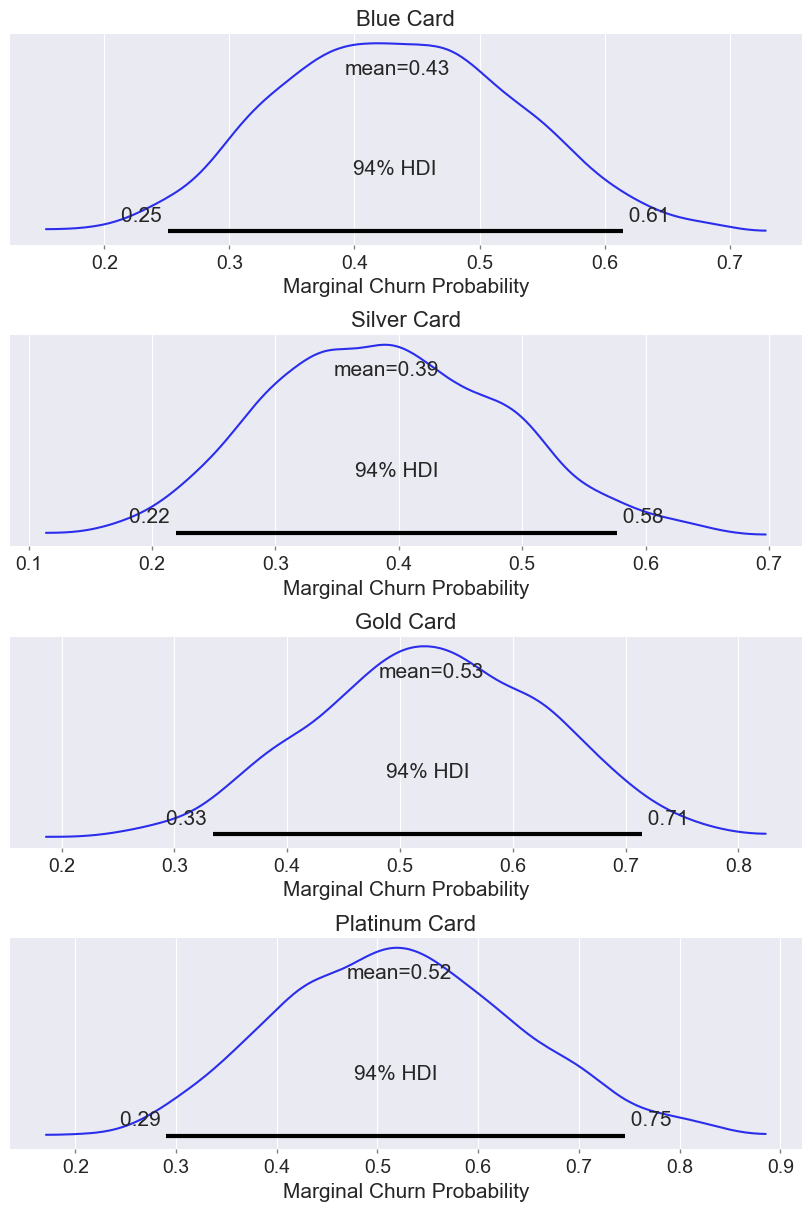

In [172]:
# From the fitted probabilistic model, we can answer questions like which card retains more users without the need to design an 
# experiment. Instead, we can compare the pairwise differences between each card distribution, the associated highest
# density interval (or equivalently the highest posterior density) for the distribution difference, and a reference value
# of 0. 

# The HDI interval of 94% is arbitrary. The combination of a HDI with a reference value at 0 allows us to be uncertain 
# if there's a difference when the HDI includes 0, or 97% certain a difference exists, given the data and the model.
# Below we see a significant difference between Silver and Gold cards with respect to churn probability. 


_, ax = plt.subplots(4, 1, figsize=(8, 12), constrained_layout=True)
for i, name in enumerate(card_names):
    az.plot_posterior(logistic(trace["card"][:, i]), ax=ax[i], hdi_prob=0.94)
    ax[i].set_title(f"{name} Card")
    ax[i].set_xlabel("Marginal Churn Probability")
plt.show()

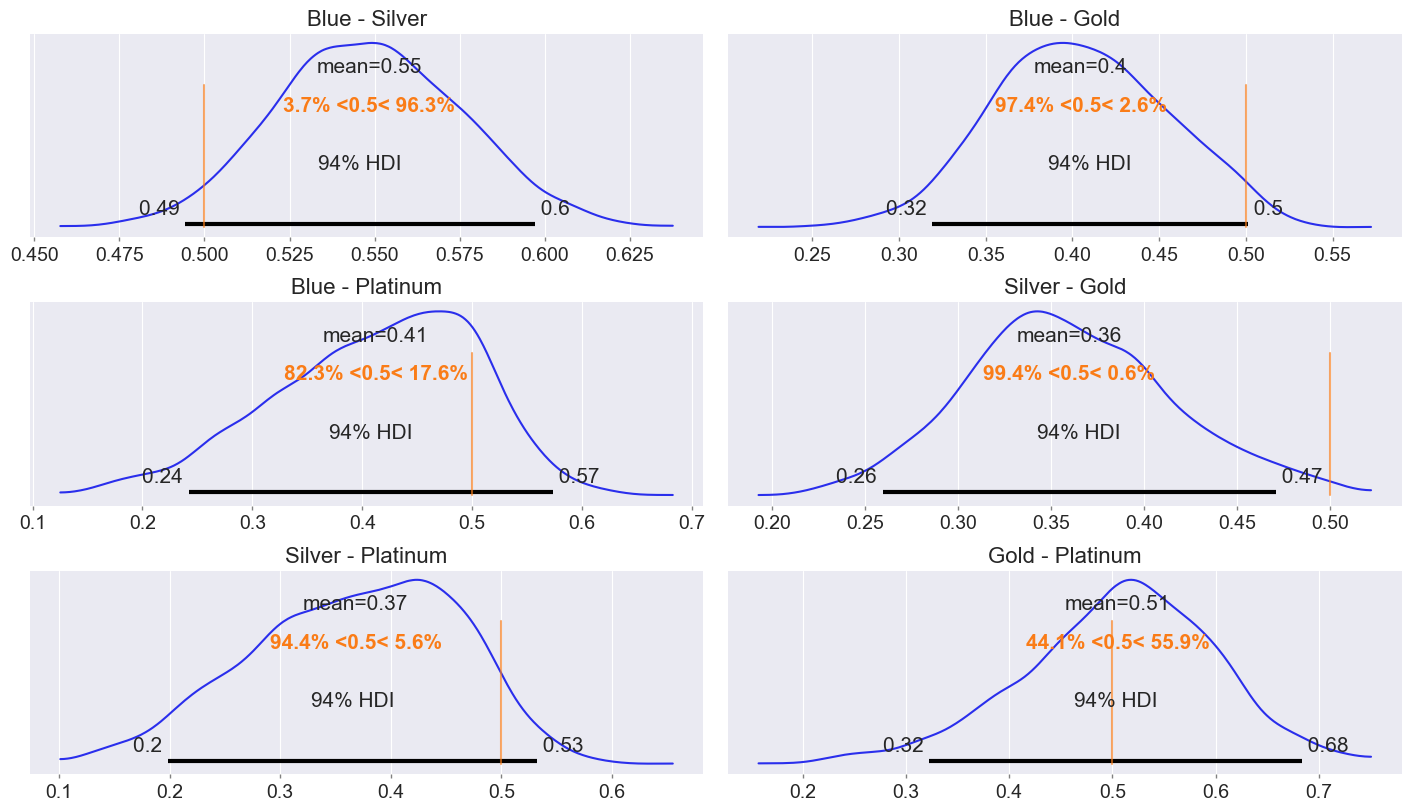

In [175]:
# Plotting the differences in churn between cards, with the x axis in probability space. Subtracting 0.5 from the mean 
# gives a relative difference between cards. HDIs that don't include the reference value of 0.5 can be considered significant.

# Below we can see a significant difference between the silver and gold cards (nearly 15% jump in churn for Gold card
# customers compared to Silver card customers), which could warrant a further investigation / deep dive into why such a 
# large difference exists between neighboring card tiers

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]
card_names = ["Blue", "Silver", "Gold", "Platinum"]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace["card"][:, i] - trace["card"][:, j]
    az.plot_posterior(means_diff, ref_val=0.5, ax=ax[k, l], hdi_prob=0.94, transform=logistic)
    ax[k, l].set_title(f"{card_names[i]} - {card_names[j]}")
plt.show()